# This is the template for coursework B - Add a suitable title

<div class="alert alert-block alert-danger">
<b>Candidate number: Your candidate number here (this is a five digit number). </b>

- This Coursework contributes <b>80%</b> to your overall unit mark.

- Will be marked anonymously.

- Keep to word limits (+- a few words).

- You can use the WordCounter notebook to check your word count.

- Code & figure captions do not count towards word limits.
</div>

### Abstract: 

Here, give an overview of your work, make sure to describe the science background, methods, results as well as comparisons to literature data. Keep this short.
<div class="alert alert-block alert-danger">
    
<b>word limit 250 words.</b>

#### Imports: give all your imports in a box here. Any custom code you have stored in a .py file needs to be submitted with your coursework. You can freely use all code provided to you as part of this course. If you use code not encountered in the course, give a link to the online repo.

In [227]:
#Data handling
import numpy as np
import pandas as pd 
from astropy.io import fits #used to open fits files in which data are stored
import glob

#Signal processing imports
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import scipy 

#Modelling imports 
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import pymc3_ext as pmx

#Visualization imports 
import arviz as az
import corner
import matplotlib.pyplot as plt
import seaborn as sns

#Progress bars
import tqdm
from typing import Optional

#Utils file 
from utils import fold_lightcurve, model_curve


<div class="alert alert-block alert-danger">
<b>Make sure to include the relevant python files in your upload</b>

### 1. Introduction:

Give an introduction to your coursework. This should be a short description of exoplanets as well as a description of background relevant to your Discussion.

Your introduction should be understandable to a student having taken Intro to astro and Planets & Exoplanets. 

<div class="alert alert-block alert-danger">
<b>Word limit: 600 words</b>

A central problem in astronomy is the search for other planets bearing life.
In recent years TESS George R. Ricker(2018) surveys have discovered thousands of confirmed exoplanets orbiting a range of stellar hosts. Of these confirmed transits indicating an exoplanet orbiting a star, only a small subset of these bodies are candidates for hosting life. There has consequently been a large body of research (CITE ME) on generating likely candidates for habitable exoplanets from large-scale sky surveys such as TESS or KEPLER- Michael Mewhinney (2013).



Keystone indicators for habitability come from a range of sources; from time series data of the stellar flux of a star, we can detect exoplanets by periodic drops in flux. These troughs, coined 'transits' by astronomers, are caused by the partial occlusion of the view of a star from an observation telescope.
After confirming the presence of an exoplanet, astronomical spectrometry and radial velocity can be used to find the exoplanet's mass, atmospheric composition, and temperature as the key indicators of suitability for life.
Before justifying this extra analysis and instrument time however, we can look at the transit curves to derive the mass ratio of the host star and exoplanet and the orbit's semi-major axis.


Additionally, measuring stellar and transit parameters allows researchers to further describe the exoplanet's path through space, and by extension confidence in their astrophysical model. Parameters of interest are the stellar limb darkening (the extent to which the central part of the star 'disk' seems brighter than its edges), the impact parameter (the verticle elevation distance between the center of the star and the exoplanet as defined below)

$$ b = \frac{a cos(i)}{R_{*}}$$


Often the extent to which a given exoplanet's orbit deviates from being circular, its eccentricity, is also considered a prominent factor in habitability, Yuwei Wang(2017).

Striving to be confident in their results for exoplanet measurements, instead of expressing these quantities as scalars, many astronomers choose to treat transit light curve data as a stochastically variable time series. Researchers can obtain probabilistic estimates of the parameters characterizing these transits using gaussian process or Markov-chain Monte Carlo (MCMC) simulations. These models yield bayesian estimates for their parameters, allowing for rigorous considerations of error, confidence, and parameter correlation.


In this work, we will perform an in-depth analysis of a reading of stellar flux from the Kepler telescope to confirm the existence of two orbiting exoplanets. Using various periodograms, we will derive estimates of the number of exoplanets in the stellar system and their respective orbital periods. After this, we will find their mass ratio and average transit length, taking an average over a series of transits.


Additionally, for the body with the larger semi-major axis more rigorous analysis will be applied- we will fit a gaussian process model to its folded light curve. From this model, we will generate estimates of the posterior distribution for stellar properties, orbital parameters, and transit jitter. This will allow us to describe the environment of the exoplanet, and by extension, its suitability for hosting life. Following this, we will perform statistical analysis on the goodness of fit of the transit light curve for all found exoplanets, and any correlations in model parameters that may affect our predictions.

### 2. Results - Modelling of Kepler lightcurve

$\bullet$ describe fitting of transit depths and present results with errors

$\bullet$ describe periodogram and identification of periodic features in lightcurves

$\bullet$ describe motivation for any additional fitting you have done

$\bullet$ include code for all modelling in attached code or inline, describe limitations and assumptions made

<div class="alert alert-block alert-danger">
    
<b>Keep this concise: word limit 750 words</b>

In [433]:
mykepler = '1'

<h2>Data Parsing</h2>	


To find a transit where there has been a noticable drop in the flux as a function of time, first we must load the data in and handle it effectively. 

Each of the 17 data subsects has a different magnitude of flux; for analysis of the light curve we want a 'smooth' time series without large scale 
step jumps. To get this, we normalize the flux and flux by dividing by the sample mean of the flux. 

We want to increase our signal precision by smoothing it, taking care not to distort its tendancy. To do this we use a Savitzky–Golay filter which 
fits a low order polynomial to data subsamples of a specific sample size which can be combined to find a smoothed signal. We do this 

In [431]:
#Get arrays for the flux so that we can do further analysis 
savgol_filter_window_size = 271
savgol_filter_poly_order = 3
total_flux, total_time, total_flux_error = [], [], []

for lcfile in tqdm.tqdm(glob.glob('Data/Object%slc/kplr*.fits' %(mykepler))):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    #Remove Nans for flux and flux error 
    tmpflux_mask, tmperror_mask  = np.isfinite(tmpflux), np.isfinite(tmperror)
    total_mask = np.logical_and(tmpflux_mask, tmperror_mask)
    time_sample, flux_sample, flux_sample_error = tmptime[total_mask], tmpflux[total_mask], tmpflux[total_mask]

    #Normalize the flux to be centred around one
    normalized_flux, normalized_flux_error = (flux_sample / np.mean(flux_sample)), (flux_sample_error / np.mean(flux_sample))

    #Run a savgol filter to do outlier removal 
    from scipy.signal import savgol_filter
    interp_savgol = savgol_filter(normalized_flux, window_length=savgol_filter_window_size, polyorder=savgol_filter_poly_order)

    total_flux.append(normalized_flux/ interp_savgol)
    total_flux_error.append(normalized_flux_error / interp_savgol)
    total_time.append(time_sample)

    tmp.close()

100%|██████████| 17/17 [00:00<00:00, 96.12it/s]


In [432]:
#Quick correction to get one array for flux, flux_err and time sorted in order. This is needed for some temporal modelling downstream
flux_arr = np.concatenate(total_flux)
flux_error_arr = np.concatenate(total_flux_error)
time_arr = np.concatenate(total_time)

sorted_flux = np.array([x for _, x in sorted(zip(time_arr, flux_arr), key=lambda pair: pair[0])])
sorted_time = np.array([_ for _, x in sorted(zip(time_arr, flux_arr), key=lambda pair: pair[0])])
sorted_flux_err = np.array([x for _, x in sorted(zip(time_arr, flux_error_arr), key=lambda pair: pair[0])])

Next, we look at the distribution of the flux and the flux errors. We want to know the distribution for fitting 
priors in any bayesian models, but also a general sense of skew and kurtosis to think about what statistical models would 
work best

/tmp/ipykernel_102241/3300366743.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(flux_err)


<AxesSubplot: ylabel='Density'>

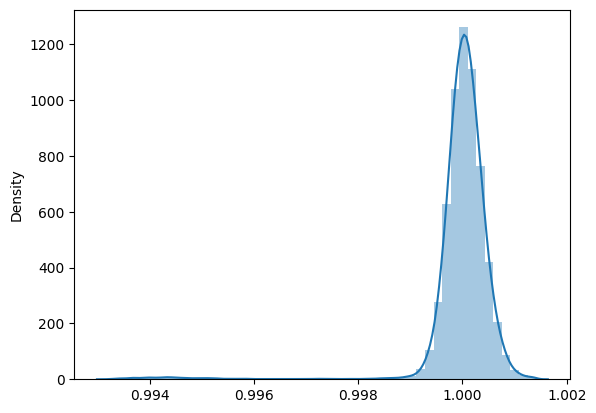

In [231]:
#Get the distribution of flux and flux errors so we can make choice as to how to model goodness of fit 
sns.distplot(flux_err)

/tmp/ipykernel_102241/4147057201.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(flux)


<AxesSubplot: ylabel='Density'>

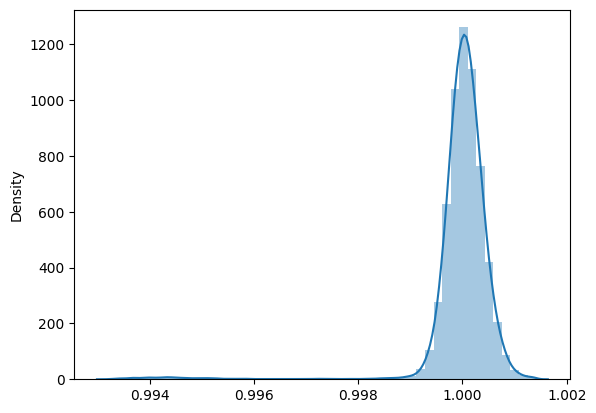

In [232]:
#Distribution of flux
sns.distplot(flux)

Both flux and it's error term seem, quantify this by looking at kurtosis 

In [233]:
print(f"""
flux kurtosis : {scipy.stats.kurtosis(flux_arr)} 
flux error kurtosis: {scipy.stats.kurtosis(flux_error_arr)}"""
)


flux kurtosis : 52.75267825320591 
flux error kurtosis: 52.75267825320591


Both distributions have a kurtosis much larger than 3 which is what it would be for standard normal distrbution. This means that goodness of fit tests
that don't heavily weight distribution tails such as chi-squared would be best for evaluation rather than a Kolmogorov-Smirnov test.

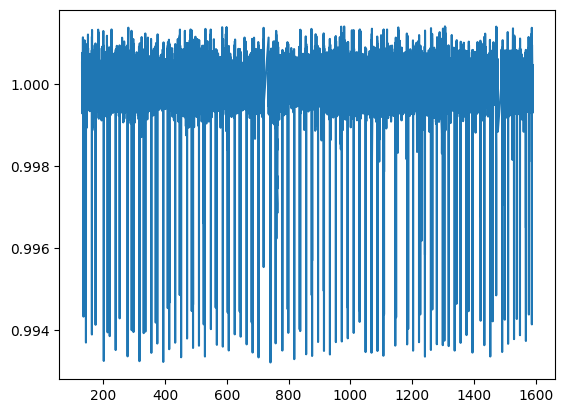

In [234]:
#Perform sigma clipping above the mean to clean the signal 
num_sigma = 2
num_sigma_above_mean = np.mean(sorted_flux) + num_sigma * (np.std(sorted_flux))

flux_value_mask = np.logical_and([x < num_sigma_above_mean for x in sorted_flux],  [x > -1000 for x in sorted_flux])
flux, flux_err, time = sorted_flux[flux_value_mask], sorted_flux_err[flux_value_mask], sorted_time[flux_value_mask]

#Remove single erroneous data point 
plt.plot(time, flux)

WRITE ABOUT LOMBSCARGLE SIGNAL PROCESSING 

In [235]:
#time_arr
dt = time_arr[1] - time_arr[0]
T = time_arr[-1] - time_arr[0]

import scipy.signal
from scipy.signal import lombscargle
freqs = np.linspace((1/T),(1/dt), 2000)
lomb = scipy.signal.lombscargle(time_arr, flux_arr, freqs, precenter=True)

In [236]:
freqs = np.linspace((1/T),(1/dt), 2000)


import scipy.signal
from scipy.signal import lombscargle
lomb = scipy.signal.lombscargle(time_arr, flux_arr, freqs, precenter=True)

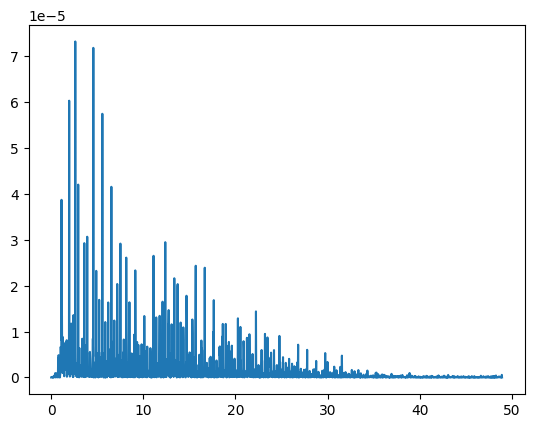

In [237]:
plt.plot(freqs, lomb)

In [238]:
period = np.linspace(1, freqs[-1], 2000)
lomb2 = lombscargle(freqs, lomb, period, precenter = True)

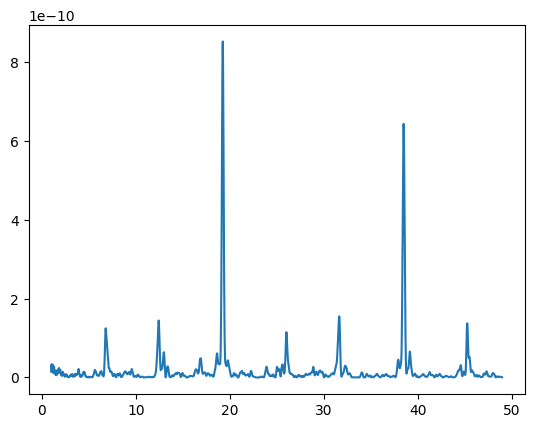

In [239]:
plt.plot(period, lomb2)

In [240]:
periods_found_from_lomb = [19.221, 38.433512752318606]


    period : 19.222997314785374,
    transit guess : 145.81301296925517,
    depth_guess : 0.002117254522572354
    


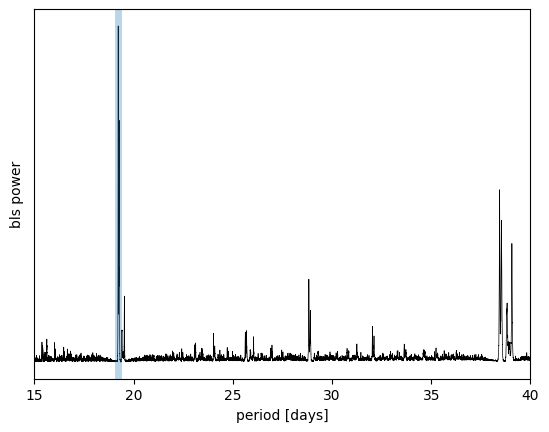

In [241]:
#Find the period, transit and peak guesses using a box least squares estimator for greater accuracy
pg = xo.estimators.bls_estimator(time, flux, flux_err, min_period=15, max_period=40)

peak = pg["peak_info"]
period_guess = peak["period"]
t0_guess = peak["transit_time"]
depth_guess = peak["depth"]

print(f"""
    period : {period_guess},
    transit guess : {t0_guess},
    depth_guess : {depth_guess}
    """
)



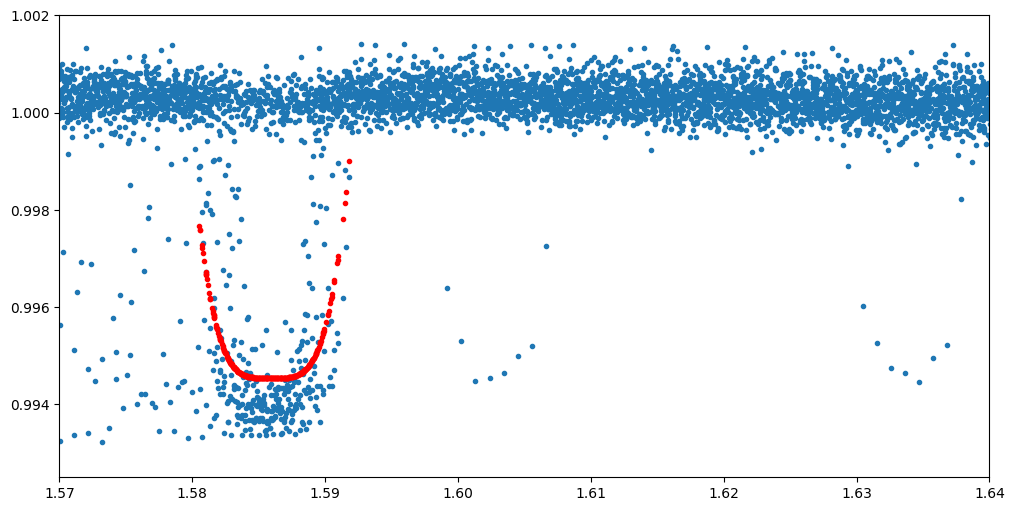

In [242]:
#Fold the lightcurve to get the transit using the period of the main found planet 
time_final, p_final, pflux_final, pflux_error_final = fold_lightcurve(
                                            time.tolist(), 
                                            flux.tolist(), 
                                            flux_err.tolist(), 
                                            period_guess
    )
#Define masks to fit the transit curve to, and a second for nice visualisation 
area_mask = (p_final > 1.5805) & (p_final < 1.593) & (pflux_final < 0.9995)
plot_mask = (p_final < 1.7) & (p_final > 1.5) 

#Fit the curve
popt, cov = curve_fit(model_curve, p_final[area_mask], pflux_final[area_mask], p0 = [0.994, 1.58, 1.593])

#Draw the figure 
plt.figure(figsize = (12, 6))
plt.plot(p_final[plot_mask], pflux_final[plot_mask], ls="None", marker="o", ms=3)#ls = 'none')
plt.plot(p_final[area_mask], model_curve(p_final[area_mask], *popt), 'r',ls="None", marker="o", ms=3)

plt.xlim(1.57, 1.64)
plt.ylim(0.9925, 1.002)
plt.show()

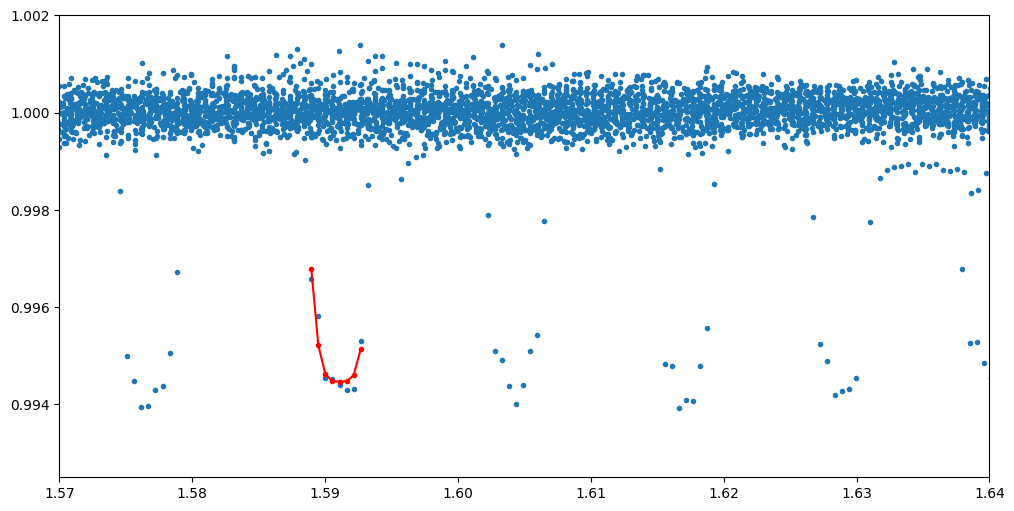

In [243]:
time_final, p_final, pflux_final, pflux_error_final = fold_lightcurve(
                                            time.tolist(), 
                                            flux.tolist(), 
                                            flux_err.tolist(), 
                                            periods_found_from_lomb[1]
    )

#area_mask = (p_final > 1.5985) & (p_final < 1.595) & (pflux_final < 0.9985)


area_mask = (p_final > 1.585) & (p_final < 1.593) & (pflux_final < 0.999)
plot_mask = (p_final < 1.7) & (p_final > 1.5) 

#Fit the curve
popt, cov = curve_fit(model_curve, p_final[area_mask], pflux_final[area_mask], p0 = [0.994,  1.587, 1.595])
#tester = model_curve(p_final[area_mask], 0.994, 1.589, 1.598)

plt.figure(figsize = (12, 6))

plt.plot(p_final[plot_mask], pflux_final[plot_mask], ls="None", marker="o", ms=3)#ls = 'none')
#plt.plot(p_final[area_mask], tester, ls="None", marker="o", ms=3)#ls = 'none')
plt.plot(p_final[area_mask], model_curve(p_final[area_mask], *popt), 'r-', marker="o", ms=3)

plt.xlim(1.57, 1.64)
plt.ylim(0.9925, 1.002)
plt.show()

WHAT DO WE GET FROM DOING THIS? 

1. Radius ratio of planet to star 
2. Period of orbit
    can find semi major axis from this 


In [346]:
#Take only the data samples within 0.25 days of a transit 
transit_mask = (
    np.abs(
        (time - t0_guess + 0.5 * period_guess) % period_guess - 0.5 * period_guess
    )
    < 0.25
)
#Data cleaning, ensure that all are float64 arrays before modelling
x = np.ascontiguousarray(time[transit_mask])
y = np.ascontiguousarray(flux[transit_mask])
yerr = np.ascontiguousarray(flux_err[transit_mask])

x_fold = (
    x - t0_guess + 0.5 * period_guess
) % period_guess - 0.5 * period_guess

#Custom mask - used to remove the 'top' line' of the transit, this isn't really needed but allows final visualization plot to look nicer 
x_fold_cord_mask = (x_fold > -0.09) & (x_fold < 0.09)
final_mask = ~np.logical_and(x_fold_cord_mask, (y > 0.999))

In [347]:
x = x[final_mask]
x_fold = x_fold[final_mask]
y = y[final_mask]
yerr = yerr[final_mask]

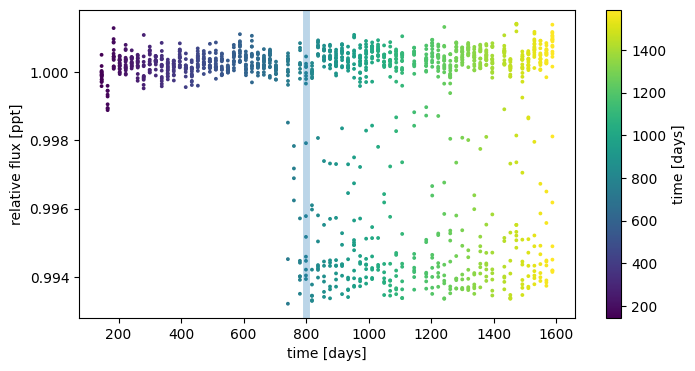

In [348]:
#Show the data that is being fitted to
plt.figure(figsize=(8, 4))
plt.scatter(x, y, c=x, s=3)
plt.axvline(800, alpha=0.3, linewidth=5)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")

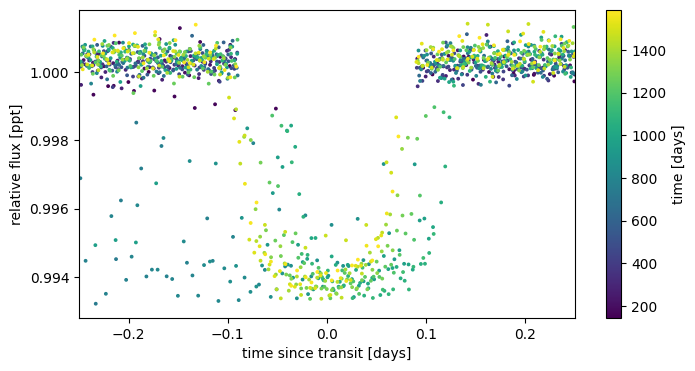

In [349]:
plt.figure(figsize=(8, 4))
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

By trying to dialias I have lost the light curve transits for the first 800 day datapoints. 

In the folded curve, we can see aliasing causing noise up until around 900 days in. 

Deal with this by clipping data at 900 days

Missing transits before around 900 days introducing lots of noise into fold, restrict fit to only the last 800 days 

In [354]:
X_mask_alias = [x > 900]

x = x[X_mask_alias]
x_fold = x_fold[X_mask_alias]
y = y[X_mask_alias]
yerr = yerr[X_mask_alias]

/tmp/ipykernel_102241/3252354323.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[X_mask_alias]
/tmp/ipykernel_102241/3252354323.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x_fold = x_fold[X_mask_alias]
/tmp/ipykernel_102241/3252354323.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  y = y[X_mas

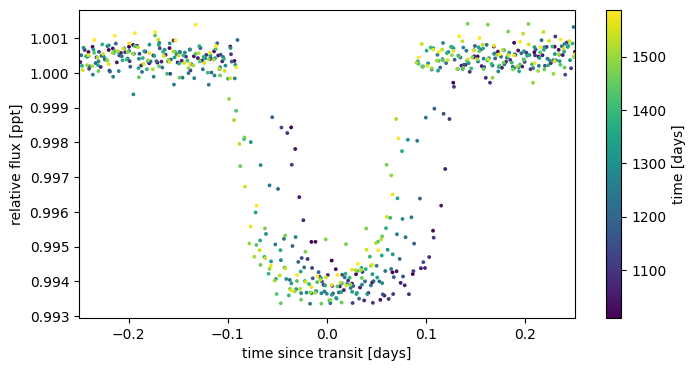

In [355]:
plt.figure(figsize=(8, 4))
plt.scatter(x_fold, y, c=x, s=3)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

Much nicer!


1. MCMC Model 

In [356]:
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

depth_guess = 0.0057
with pm.Model() as model_reduced:
    
    # Stellar parameters
    mean = pm.Normal("mean", mu=1.0006, sigma=0.001)
    u = xo.QuadLimbDark("u")
    star_params = [mean, u]

    # Planet parameters
    log_ror = pm.Normal(
        "log_ror", mu=0.5 * np.log(depth_guess * 1e-3), sigma=0.1
    )
    ror = pm.Deterministic("ror", tt.exp(log_ror))

    #Noise parameter
    sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(yerr))

    # Orbital parameters
    log_period = pm.Normal("log_period", mu=np.log(period_guess), sigma=0.1)
    period = pm.Deterministic("period", tt.exp(log_period))
    t0 = pm.Normal("t0", mu=t0_guess, sigma=1.0)
    log_dur = pm.Normal("log_dur", mu=np.log(0.18), sigma=0.10)
    dur = pm.Deterministic("dur", tt.exp(log_dur))
    b = xo.distributions.ImpactParameter("b", ror=ror)

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=period, 
        duration=dur, 
        t0=t0, 
        b=b,
        )

    # We're going to track the implied density for reasons that will become clear later
    pm.Deterministic("rho_circ", orbit.rho_star)

    # Set up the mean transit model
    star = xo.LimbDarkLightCurve(u)
    lc_model = mean + 1e3 * tt.sum(
        star.get_light_curve(orbit=orbit, r=ror, t=x), axis=-1
    )


    # Double check that everything looks good - we shouldn't see any NaNs!
    print(model_reduced.check_test_point())

    # Optimize the model
    map_soln = model_reduced.test_point
    map_soln = pmx.optimize(map_soln, [ror, b, dur])
    map_soln = pmx.optimize(map_soln, sigma)

    map_soln = pmx.optimize(map_soln, star_params)
    map_soln = pmx.optimize(map_soln)

/home/cm2435/anaconda3/envs/astrophysics/lib/python3.8/site-packages/exoplanet/orbits/keplerian.py:120: UserWarning: When using the 'duration' parameter in KeplerianOrbit, the 'ror' parameter should also be provided.
  warnings.warn(


mean                5.99
u_quadlimbdark__   -2.77
log_ror             1.38
sigma_log__        -0.53
log_period          1.38
t0                 -0.92
log_dur             1.38
b_impact__         -1.39
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [log_dur, b, log_ror]


message: Optimization terminated successfully.
logp: 4.527665038484839 -> 4.5276707113809636


optimizing logp for variables: [sigma]


message: Optimization terminated successfully.
logp: 4.5276707113809636 -> 4.6646244940175166


optimizing logp for variables: [u, mean]


message: Optimization terminated successfully.
logp: 4.6646244940175166 -> 4.6646244940175166


optimizing logp for variables: [b, log_dur, t0, log_period, sigma, log_ror, u, mean]


message: Optimization terminated successfully.
logp: 4.6646244940175166 -> 4.6646244940175166


In [357]:
with model_reduced:
    #Predict values for the light curve
    lc_pred = pmx.eval_in_model(lc_model, map_soln)

    trace_small = pm.sample(
        tune=4000,
        draws=4000,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136679, 261136680],
        init="adapt_full",
    )
import pickle 
with open("trace.pkl", "wb") as f: 
    pickle.dump(trace_small, f)

/tmp/ipykernel_102241/1063318980.py:5: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace_small = pm.sample(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
INFO:pymc3:Initializing NUTS using adapt_full...
/home/cm2435/anaconda3/envs/astrophysics/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, log_dur, t0, log_period, sigma, log_ror, u, mean]
INFO:pymc3:NUTS: [b, log_dur, t0, log_period, sigma, log_ror, u, mean]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.
INFO:pymc3:Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.


In [358]:
with model_reduced:
    sample_summary = az.summary(trace_small)

#stellar density has sample cases where due to overflow it is NAN, this will be cleaned up manually later.
sample_summary

arviz - WARNING - Array contains NaN-value.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,1.001,0.001,0.999,1.002,0.000,0.000,12284.0,6763.0,1.0
log_ror,-6.038,0.100,-6.222,-5.847,0.001,0.001,11546.0,6123.0,1.0
log_period,2.956,0.099,2.769,3.141,0.001,0.001,12317.0,6320.0,1.0
t0,145.818,0.989,143.886,147.634,0.009,0.006,12480.0,6152.0,1.0
log_dur,-1.715,0.099,-1.900,-1.526,0.001,0.001,10774.0,6209.0,1.0
u[0],0.667,0.476,0.000,1.516,0.005,0.004,9842.0,4884.0,1.0
u[1],-0.000,0.411,-0.786,0.731,0.004,0.005,9449.0,5435.0,1.0
ror,0.002,0.000,0.002,0.003,0.000,0.000,11546.0,6123.0,1.0
sigma,1.006,0.961,0.170,2.281,0.014,0.010,9680.0,4597.0,1.0
period,19.321,1.922,15.772,22.919,0.017,0.013,12317.0,6320.0,1.0


In [359]:
sample_summary['sd']['mean']

0.001

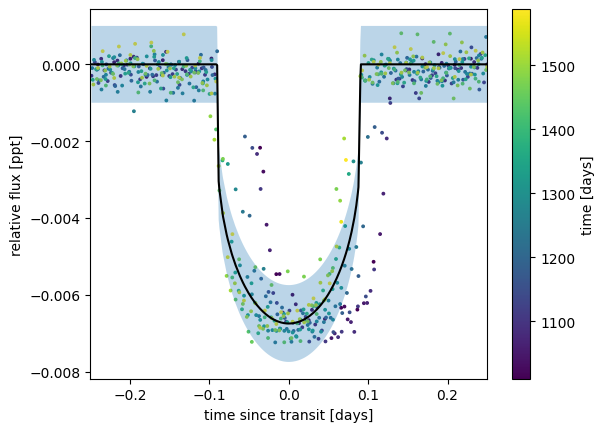

In [360]:
inds = np.argsort(x_fold)
plt.scatter(x_fold, y  - map_soln["mean"], c=x, s=3)
plt.plot(x_fold[inds], lc_pred[inds] - map_soln["mean"], "k")
plt.fill_between(x_fold[inds],
            y1 = lc_pred[inds] - map_soln["mean"] - sample_summary['sd']['mean'], 
            y2 = lc_pred[inds] - map_soln["mean"] + sample_summary['sd']['mean'],
            alpha = 0.3
    )
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]")
plt.colorbar(label="time [days]")
_ = plt.xlim(-0.25, 0.25)

### 3. Discussion

$\bullet$ present comparison of your results with data, including statistical analyis and clear figures. 

$\bullet$ limit yourself in the presentation of results, focus on fewer results that are described well, rather than presenting many figures without clear context

$\bullet$ Include a short (~ 200 word) description of a follow-up observations that would address an open question in your report.


<div class="alert alert-block alert-danger">
<b>Word limit: 2000 words</b>

1. \b Finding eccentricity

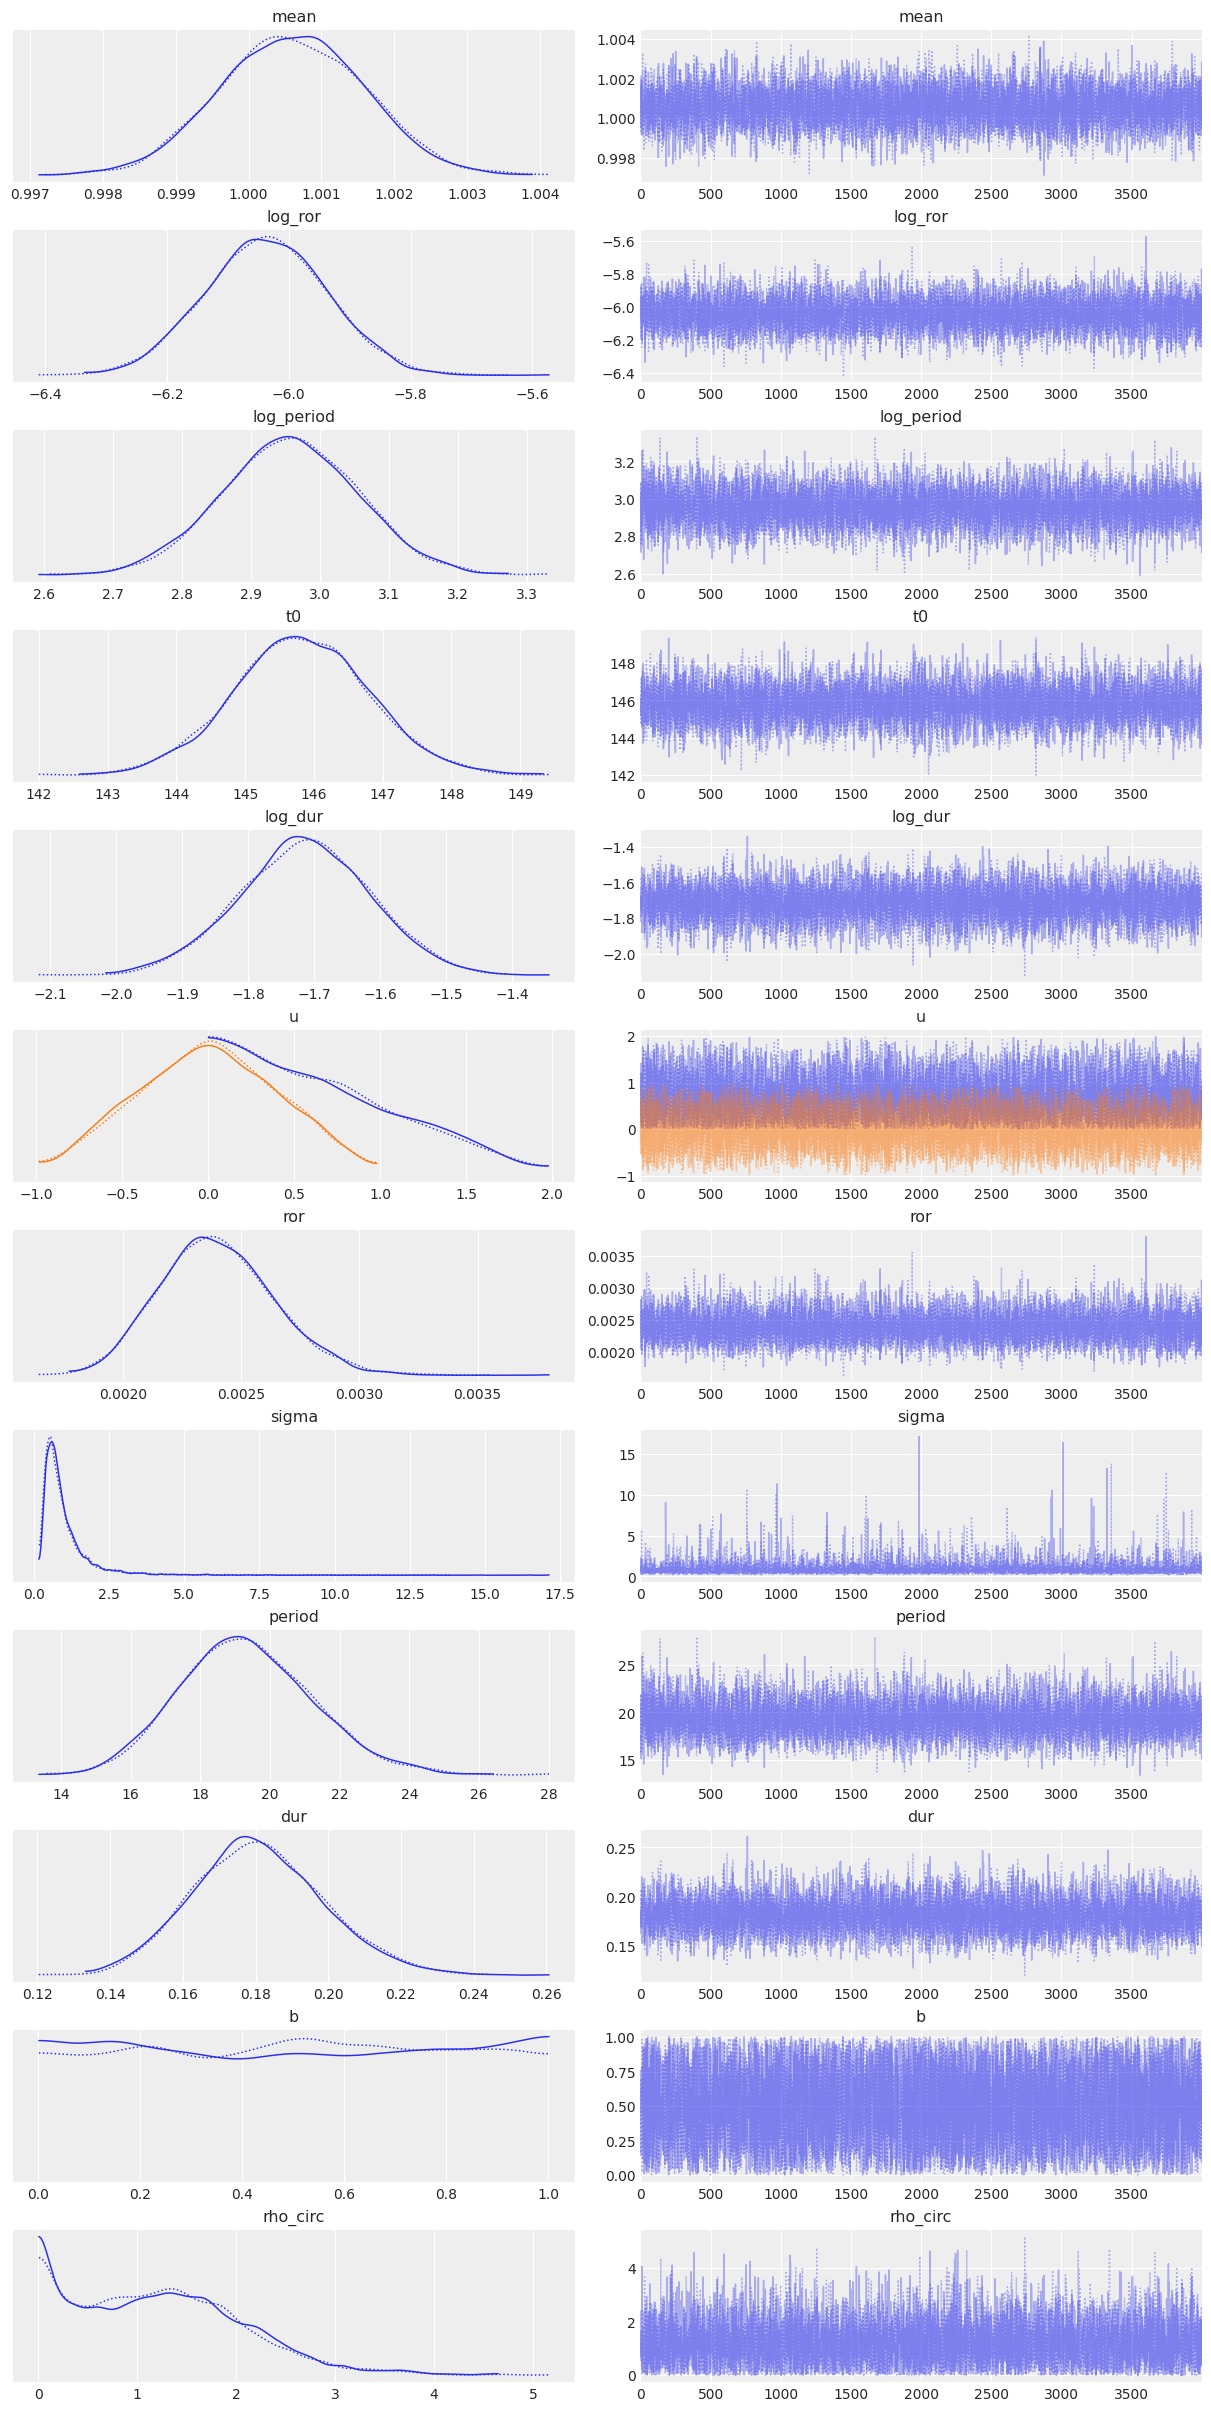

In [430]:
import arviz as az
az.style.use("arviz-darkgrid")

with model_reduced:
    az.plot_trace(trace_small,)

Look at the distribution graphs for chain 1 and 2 to see if in agreement

/tmp/ipykernel_102241/3645760978.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(chain_rho_circ_2)


<AxesSubplot: ylabel='Density'>

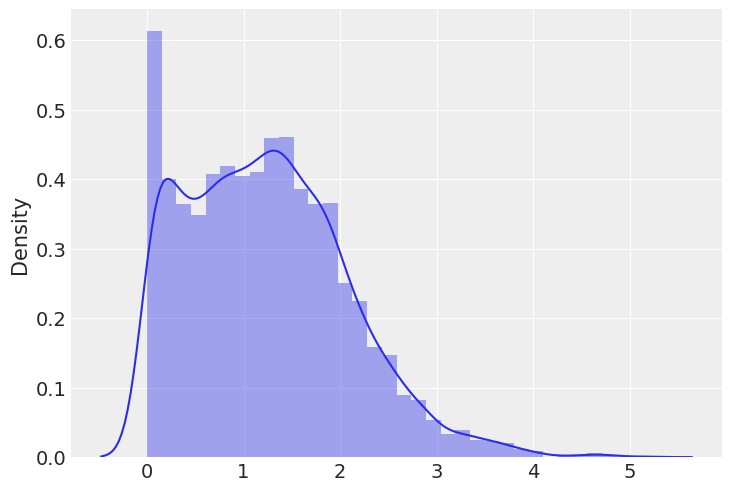

In [402]:
sns.distplot(chain_rho_circ_2)

/tmp/ipykernel_102241/1091723942.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(chain_rho_circ_1)


<AxesSubplot: ylabel='Density'>

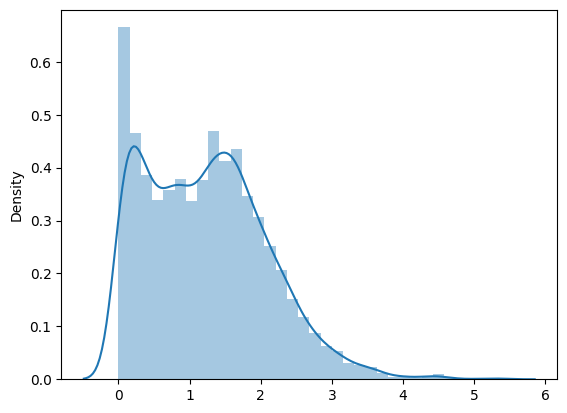

In [366]:
sns.distplot(chain_rho_circ_1)

In [368]:
#On trace plot chains visably diverge, check the z score to see if chains reasonably drawn from same distribution and can be averaged.
chain_rho_circ_1 = trace_small.posterior["rho_circ"].to_numpy()[0]
chain_rho_circ_2 = trace_small.posterior["rho_circ"].to_numpy()[1]
mask = np.logical_and(np.isfinite(chain_rho_circ_1), np.isfinite(chain_rho_circ_2))

#Find the z score for the two samples 
(np.mean(chain_rho_circ_1[mask]) - np.mean(chain_rho_circ_2[mask])) / np.sqrt(np.std(chain_rho_circ_1[mask]**2)-np.std(chain_rho_circ_2[mask])**2 )

0.008726442884431154

Value much smaller than 2 so they are drawn from the same sufficiently 'stable' distribution and chains are in agreement

Equivelent to a p value of approx 0.996 or nearly 3 sigma 

In [378]:
rho_circ = np.repeat(np.asarray(trace_small.posterior["rho_circ"]).flatten(), 100)
rho_mask = np.isfinite(rho_circ)
rho_circ = rho_circ[rho_mask]

#Taken from assumed stellar mass and radius being 1 stellar mass and radius pm 2%
#Density = mass / volume of sphere, uses r^3 and mass once, linear operations yield
# Additive errors so it is 0.02 * 4 for error prop.
tic_rho_star = (1, 0.08)

eccentricity = 0.28 +0.32 -0.19


/home/cm2435/anaconda3/envs/astrophysics/lib/python3.8/site-packages/corner/core.py:103: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


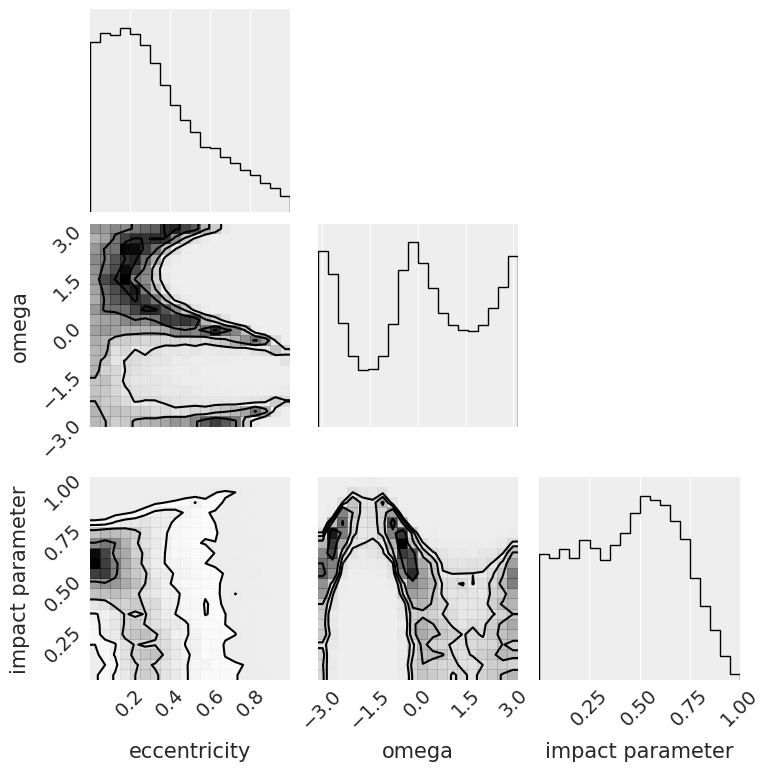

In [403]:
#Pull out the impact parameter b for corner plot
impact = np.repeat(np.asarray(trace_small.posterior["b"]).flatten(), 100)[rho_mask]

# Sample eccentricity and omega from their (uninformative) priors
ecc = np.random.uniform(0, 1, len(rho_circ))
omega = np.random.uniform(-np.pi, np.pi, len(rho_circ))

# Compute the "g" parameter from Dawson & Johnson and what true
# density that implies
g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc**2)
rho = rho_circ / g**3

# Re-weight these samples to get weighted posterior samples
log_weights = -0.5 * ((rho - tic_rho_star[0]) / tic_rho_star[1]) ** 2
weights = np.exp(log_weights - np.max(log_weights))

# Estimate the expected posterior quantiles
q = corner.quantile(ecc, [0.16, 0.5, 0.84], weights=weights)
print(
    "eccentricity = {0:.2f} +{1[1]:.2f} -{1[0]:.2f}".format(q[1], np.diff(q))
)

#Make corner plot
_ = corner.corner(
    np.vstack((ecc, omega, impact)).T,
    weights=weights,
    plot_datapoints=False,
    labels=["eccentricity", "omega", 'impact parameter'],
)

FIND SEMI MAJOR AXIS 

Keplars law 


$$ T^2 = \frac{4 \pi ^2}{GM} a^3$$

$$\frac{T^2  GM}{4 \pi ^2} = a^3$$

In [422]:
orbit_period_mean = sample_summary['mean']['period']
orbit_period_std = sample_summary['sd']['period']

stellar_mass = 1.989e30
G = 6.67e-11
au =  1.495978707e11

semi_major_axis_mean = np.cbrt((orbit_period_mean**2 * G* stellar_mass) / (4 * np.pi**2))
semi_major_axis_std = np.cbrt((orbit_period_std**2 * G* stellar_mass) / (4 * np.pi**2))

In [429]:
au_mean = semi_major_axis_mean / 10000000

Luminosity 

### 4. Summary

$\bullet$ summarize your results. This can be done in text or bullet points.

<div class="alert alert-block alert-danger">
<b>Word limit: 300 words</b>

### References:

Give all references here. Use Astronomy style references, e.g.
- Miller & Jones, 2018, ApJ, 00, 000
- Smith et al. 2019, MNRAS, 00, 000
- Willow 1972, AJ, 00, 000

And cite these in the text as "Miller & Jones (2018) showed that all exoplanets are made of cheese, however, Smith et al. (2019) showed Trappist1b is made of chocolate, as previously suggested in the literature (Willow 1972)." 


### Acknowledgments

Acknowlegde the use of any software or datasets here.